In [217]:
#Moving average stratey here uses two separate moving averages of the past 5 days and 20 days.
#When 5 days MA goes up across the 20 days' MA, we regard this as a signal for a buy 
#and it is cleared when it crosses back down. 
#it is also the same for the opposite case in which the 5 days MA goes below the 20 days MA. 
#it is short and be cleared when it crosses back up the 20 days MA. 

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import datetime
import pandas_datareader.data as web
import quandl
quandl.ApiConfig.api_key = "KuL7iL8zUg7h8iZzXh9_"

#def gen_stock_info(ticker, start, end):
def gen_stock_info():
    #stock_df = quandl.get(''.join(['WIKI/', ticker]), start_date=start, end_date=end)
    stock_df=quandl.get("BCHARTS/BITSTAMPUSD")
    stock_df = stock_df[(stock_df['Open'] != 0) & (stock_df['Close'] != 0)]
    return stock_df  #only need some columns


def add_Moving_Ave(stock_df):
    ma_list = ['ma5','ma20', 'ma60', 'ma120']
    window_list = [5, 20, 60, 120]
    for ma, window_ in zip(ma_list, window_list):
        stock_df[ma] = stock_df['Close'].rolling(window=window_).mean()
    return stock_df
    
    
def add_STD(stock_df):
    std_list = ['std_20']
    window_list = [20]
    for std, window_ in zip(std_list, window_list):
        stock_df[std] = stock_df['Close'].rolling(window=window_).std()
    return stock_df


def draw_stock(stock_df, window_=365):

    plt.figure(figsize=(20,10))
    plt.plot(stock_df.index[-window_:],stock_df.Close[-window_:],label='Close')
    plt.plot(stock_df.index[-window_:],stock_df.ma5[-window_:],label='ma5')
    plt.plot(stock_df.index[-window_:],stock_df.ma20[-window_:],label='ma20')
    #plt.plot(stock_df.index[-window_:],stock_df.ma60[-window_:],label='ma60')
    #plt.plot(stock_df.index[-window_:],stock_df.ma120[-window_:],label='ma120')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

#functions for analysis of an algorithm after simulations    
#############################   
def gen_drawdown_record(list_, K): # including up to K-th largest one
    
    record_ =[] 
    for i in range(1, len(list_)-1):
        if list_[i] > list_[i+1] and list_[i] > list_[i-1]: #find some number that are greater than the numbers next to it
            
            num_of_found = 0
            j = i+1
            while (num_of_found == 0) & (j < len(list_)):  #I can only look at the values from current point to the end
                if list_[i] <= list_[j]: #This is when I find the value recovered
                    num_of_found += 1
                    k_index, min_ = 0, 9999999999
                    
                    if num_of_found == 1: # just make sure if the value is the first recovery found
                        for k in range(i+1, j): #Then between the start and the recovery, there should be a minimum 
                            if list_[k] < list_[k+1] and list_[k] < list_[k-1]:
                                if (min_ > list_[k]):
                                    k_index, min_ = k, list_[k] #This is the minimum I find during the drawdown
               
                        record_.append((list_[i]-min_, i, j)) 
                j = j+1
    
    if K > len(record_):
        return "K is greater than the number of drawdowns"
    else:        
        return sorted(record_, key= lambda pair:pair[0], reverse = True)[:K]
    
    
def draw_result_of_sim(stock_df):
    plt.figure(figsize=(10,6))
    plt.plot(stock_df['Close'], label='Close')
    plt.plot(stock_df['Cum_profit'],label='Cumulative_profit')
    plt.plot(stock_df['Net_profit'],label='Net_profit')
    plt.legend(loc='best')
    plt.show()
    
def draw_return_dist(stock_df):
    dailyreturn = np.log(stock_df.Close)-np.log(stock_df.Close.shift(1))
    day_ret = np.array(dailyreturn[1:])
    import seaborn as sns
    from scipy import stats
    sns.distplot(day_ret, kde=True, rug=True, fit=stats.norm)    

def calc_quality_of_port(stock_df):
    return (stock_df.Cum_profit).mean()/(stock_df.Cum_profit).std()

def calc_max_drawdown(stock_df):
    max_drawdown, start_point = gen_drawdown_record(stock_df.Total_asset, 1)[0][:2]
    return -max_drawdown/(stock_df.Total_asset[start_point])*100

def get_final_total_value(stock_df):
    return stock_df.Cum_profit[-1]

In [218]:
#generate the stock info
stock_df = gen_stock_info()
stock_df = add_Moving_Ave(stock_df)
stock_df = add_STD(stock_df)
stock_df = stock_df.iloc[:,[0, 3, 7, 8]]
stock_df = stock_df.iloc[19:,:]
ref_stock_df = stock_df.copy()

In [219]:
def simulate_algo(ref_stock_df, init_cash = 1000, target_port_ratio=0.5):
    # init_cash = 1000 
    # target_port_ratio = 0.5
    stock_df = ref_stock_df.copy()
    
    # initialization
    stock_df.loc[:,'Cash']=0  
    stock_df.at[stock_df.index[0],'Cash']=init_cash
    stock_df.loc[:,'Inventory']=0
    stock_df.loc[:,'Port_val']=0
    stock_df.loc[:,'Total_asset']=0
    stock_df.at[stock_df.index[0],'Total_asset'] = stock_df.iloc[0]['Cash']+stock_df.iloc[0]['Port_val']
    stock_df.loc[:,'Net_profit']=0
    stock_df.loc[:,'Signal'] = stock_df['ma5'] > stock_df['ma20']
    stock_df.loc[:,'Signal_change'] = abs(stock_df['Signal'].shift(1) - stock_df['Signal'])
    stock_df.at[stock_df.index[0],'Signal_change'] = 0
    
    
    #functions for orders in the simulation    
    ############################# 
    def short(quantity, list_):
        open_t, close_t, Cash_t, Inventory_t = list_

        Inventory_t = Inventory_t - quantity 
        Cash_t = Cash_t + quantity * open_t
        Port_val_t = Inventory_t * close_t
        Total_asset_t = Cash_t + Port_val_t 
        Net_profit_t = Total_asset_t - Total_asset_y

        return Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t


    def long(quantity, list_):
        open_t, close_t, Cash_t, Inventory_t = list_

        Inventory_t = Inventory_t + quantity 
        Cash_t = Cash_t - quantity * open_t
        Port_val_t = Inventory_t * close_t
        Total_asset_t = Cash_t + Port_val_t 
        Net_profit_t = Total_asset_t - Total_asset_y

        return Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t


    def clear_position(quantity, list_):
        open_t, close_t, Cash_y, Inventory_y = list_

        if Inventory_y < 0: #clear some short positions
            Inventory_t = Inventory_y + quantity 
            Cash_t = Cash_y - quantity * open_t
            Port_val_t = Inventory_t * close_t
            Total_asset_t = Cash_t + Port_val_t 
            Net_profit_t = Total_asset_t - Total_asset_y

        elif Inventory_y > 0: #clear some long positions
            Inventory_t = Inventory_y - quantity 
            Cash_t = Cash_y + quantity * open_t
            Port_val_t = Inventory_t * close_t
            Total_asset_t = Cash_t + Port_val_t 
            Net_profit_t = Total_asset_t - Total_asset_y

        return Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t  

    for i in range(1,len(stock_df)): 
        #targeted_quantity = total assset * target_ratio / unit price
        known_yesterday = stock_df.iloc[i-1,:] # all info
        known_today = stock_df.iloc[i,0] #only open price at the start of the market
        unknown_today = stock_df.iloc[i,1]

        open_y, close_y, ma5_y, ma20_y, Cash_y, Inventory_y, Port_val_y, Total_asset_y, Net_profit_y, Signal_y, Signal_change_y = known_yesterday
        open_t = known_today
        close_t = unknown_today
        ref_list = (open_t, close_t, Cash_y, Inventory_y)

        targeted_quantity = Total_asset_y * target_port_ratio/open_t

        #if no signal change and the signal is false -> still ma5 < ma20
        if (Signal_change_y == 0) & (Signal_y == False):

            if targeted_quantity >= abs(Inventory_y):
                stock_df.iloc[i,[4, 5, 6, 7, 8]] = short(targeted_quantity - abs(Inventory_y), ref_list)
            elif targeted_quantity < abs(Inventory_y):
                stock_df.iloc[i,[4, 5, 6, 7, 8]] = clear_position(abs(Inventory_y)-targeted_quantity, ref_list)

        #if no signal change and the signal is True -> still ma5 > ma20
        elif (Signal_change_y == 0) & (Signal_y == True):  

            if targeted_quantity >= abs(Inventory_y):
                stock_df.iloc[i,[4, 5, 6, 7, 8]] = long(targeted_quantity - abs(Inventory_y), ref_list)
            elif targeted_quantity < abs(Inventory_y):
                stock_df.iloc[i,[4, 5, 6, 7, 8]] = clear_position(Inventory_y-targeted_quantity, ref_list)

        #if there is signal change and the changed signal is True -> now ma5 > ma20        
        elif (Signal_change_y == 1) & (Signal_y == True):

            stock_df.iloc[i,[4, 5, 6, 7, 8]] = clear_position(abs(Inventory_y), ref_list)
            ref_list_1 = open_t, close_t, stock_df.iloc[i,4], stock_df.iloc[i,5]
            stock_df.iloc[i,[4, 5, 6, 7, 8]] = long(targeted_quantity - abs(Inventory_t), ref_list_1)

        #if there is signal change and the changed signal is False -> now ma5 < ma20     
        elif (Signal_change_y == 1) & (Signal_y == False):

            stock_df.iloc[i,[4, 5, 6, 7, 8]] = clear_position(abs(Inventory_y), ref_list)
            ref_list_1 = open_t, close_t, stock_df.iloc[i,4], stock_df.iloc[i,5]
            stock_df.iloc[i,[4, 5, 6, 7, 8]] = short(targeted_quantity - abs(Inventory_t), ref_list_1)

    stock_df['Cum_profit']=stock_df['Net_profit'].cumsum()
    return stock_df

simulate_algo(stock_df)

,Open,Close,ma5,ma20,Cash,Inventory,Port_val,Total_asset,Net_profit,Signal,Signal_change,Cum_profit
Date,,,,,,,,,,,,
2011-10-05,4.92,4.92,4.882,5.2395,1000.000000,0.000000,0.000000,1000.000000,0.000000,False,0,0.000000
2011-10-06,4.88,4.80,4.878,5.1810,1500.000000,-102.459016,-491.803279,1008.196721,8.196721,False,0,8.196721
2011-10-07,4.80,4.61,4.836,5.1350,1512.295082,-105.020492,-484.144467,1028.150615,19.953893,False,0,28.150615
2011-10-08,4.57,3.99,4.660,5.0780,1546.426742,-112.489126,-448.831614,1097.595128,69.444513,False,0,97.595128
2011-10-09,3.89,3.89,4.442,5.0300,1657.641604,-141.079065,-548.797564,1108.844040,11.248913,False,0,108.844040
2011-10-10,3.99,4.51,4.360,5.0120,1649.158154,-138.952887,-626.677522,1022.480632,-86.363408,False,0,22.480632
2011-10-11,3.98,4.10,4.220,4.9710,1607.365979,-128.452341,-526.654597,1080.711382,58.230749,False,0,80.711382
2011-10-12,3.95,3.93,4.084,4.9225,1640.334924,-136.798909,-537.619713,1102.715211,22.003829,False,0,102.715211
2011-10-13,3.93,3.97,4.080,4.8380,1654.072817,-140.294556,-556.969388,1097.103429,-5.611782,False,0,97.103429


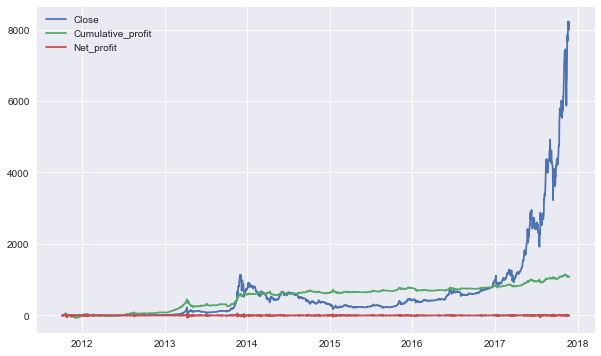

Targeted portion = 0.1 [1089.844812347535, 1.6528813603662726, -15.047452655240075]


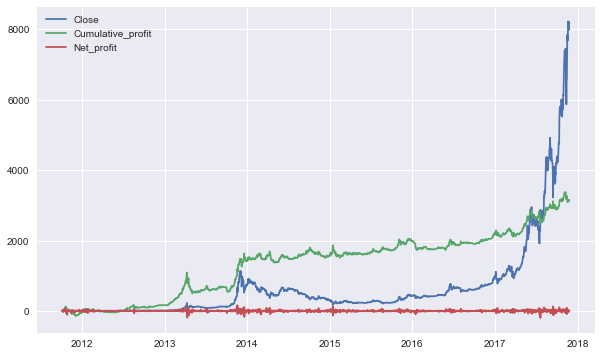

Targeted portion = 0.2 [3146.5969633367913, 1.536105266793625, -28.412384721378032]


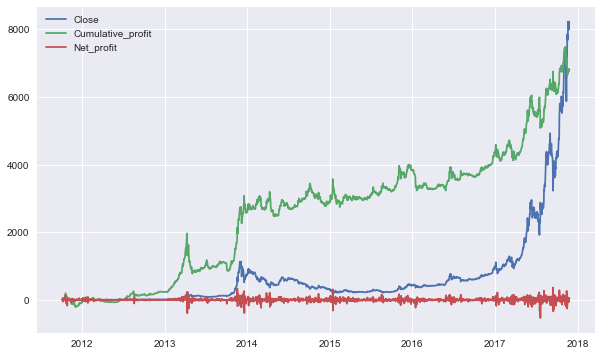

Targeted portion = 0.3 [6809.9244775093757, 1.4240725622679695, -40.185119629701745]


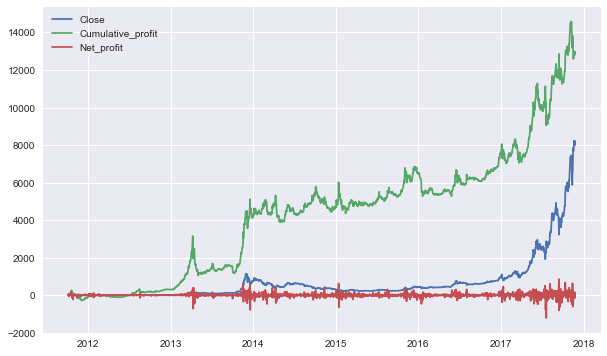

Targeted portion = 0.4 [12957.742656261915, 1.318153452931143, -18.172725986177284]


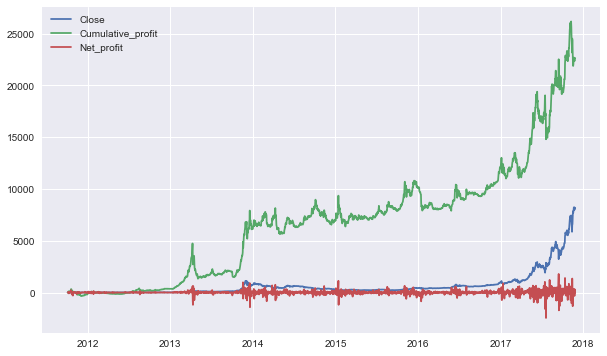

Targeted portion = 0.5 [22656.444963617636, 1.2198661265357784, -22.527984110625152]


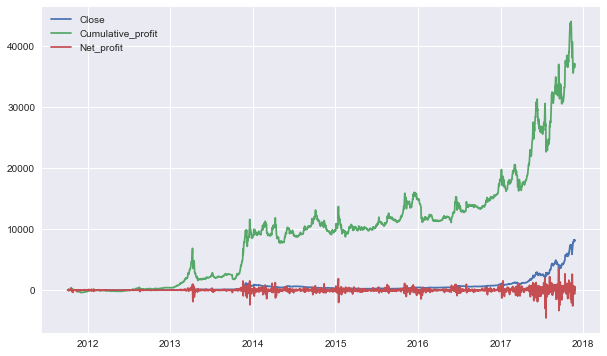

Targeted portion = 0.6 [36993.51978362113, 1.130417843276415, -26.794569653146333]


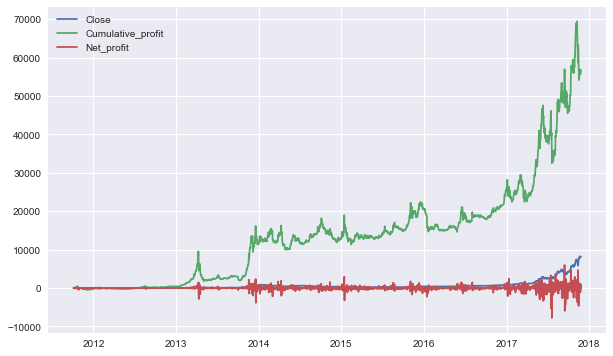

Targeted portion = 0.7 [56762.915197787217, 1.0504639847698636, -30.966452845707309]


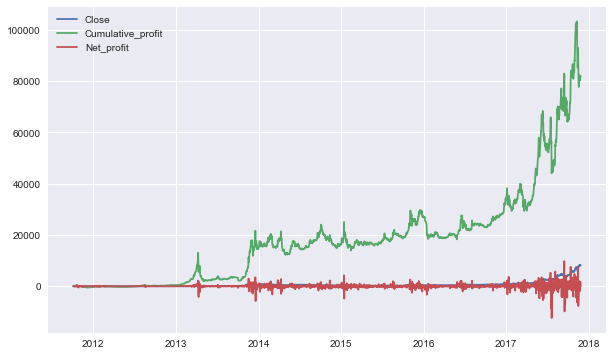

Targeted portion = 0.8 [82022.766363848408, 0.980096433601571, -35.03803349665435]


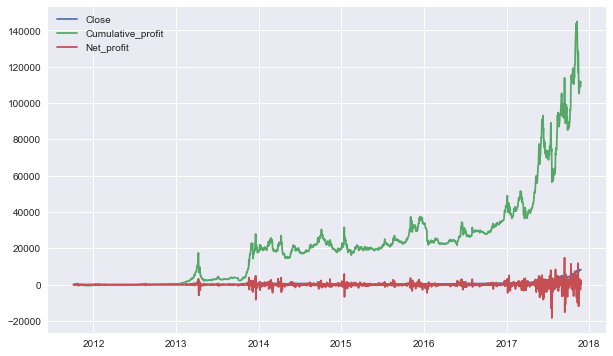

Targeted portion = 0.9 [111624.14344616333, 0.9189701803285723, -39.004149165816123]


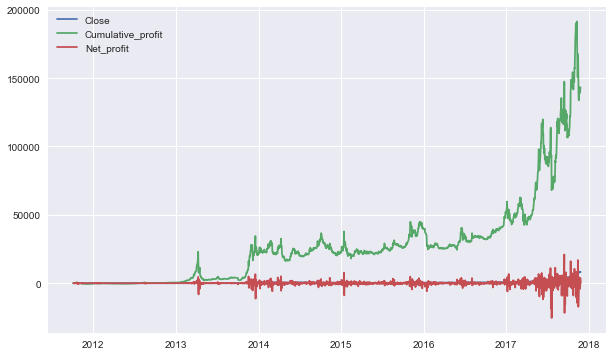

Targeted portion = 1.0 [142893.1585737993, 0.8664697047497998, -42.860081653305159]


In [220]:
test_portion_list = np.arange(0.1, 1.1, 0.1) 
result_list = []
for portion in test_portion_list:
    temp_result_df = simulate_algo(stock_df, init_cash=1000, target_port_ratio=portion)
    result_list.append([get_final_total_value(temp_result_df), calc_quality_of_port(temp_result_df), calc_max_drawdown(temp_result_df)]) 
    draw_result_of_sim(temp_result_df)
    print('Targeted portion =', portion, result_list[-1])
    

In [221]:
stock_df = simulate_algo(stock_df)
print('Initial Investment Value $ 1000.00')
print('Final Portfolio Value: $', get_final_total_value(stock_df))
print('The Quality of the Portfolio is', calc_quality_of_port(stock_df))
print('Max Drawdown is', calc_max_drawdown(stock_df), '%')

Initial Investment Value $ 1000.00
Final Portfolio Value: $ 22656.4449636
The Quality of the Portfolio is 1.2198661265357784
Max Drawdown is -22.5279841106 %
